# 教師あり学習　課題8　　学籍番号6021136 三輪俊太郎
### motorcycleデータを使用して、ガウス過程回帰を実装した。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

In [2]:
df = pd.read_csv("/Users/ShuntaroMiwa/00 python/matsui/mcycle.csv"
                 ,index_col=0)
df.dtypes

times    float64
accel    float64
dtype: object

## description https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/mcycle.html
### A data frame giving a series of measurements of head acceleration in a simulated motorcycle accident, used to test crash helmets.
### ・times：　in milliseconds after impact.
### ・accel：　in g.

In [3]:
df.head()

,times,accel
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


In [4]:
df.isnull().sum()

times    0
accel    0
dtype: int64

In [5]:
df.describe()

,times,accel
count,133.000000,133.000000
mean,25.178947,-25.545865
std,13.132063,48.322050
min,2.400000,-134.000000
25%,15.600000,-54.900000
50%,23.400000,-13.300000
75%,34.800000,0.000000
max,57.600000,75.000000


In [6]:
# 信号を欠損させて部分的なサンプル点を得る
missing_value_rate = 0.2
sample_index = np.sort(np.random.choice(np.arange(len(df)), int(len(df)*missing_value_rate), replace=False))

In [7]:
print(sample_index)

[  9  15  16  17  19  20  29  31  32  47  48  59  68  74  80  85  87  95
 103 105 112 114 115 119 127 131]


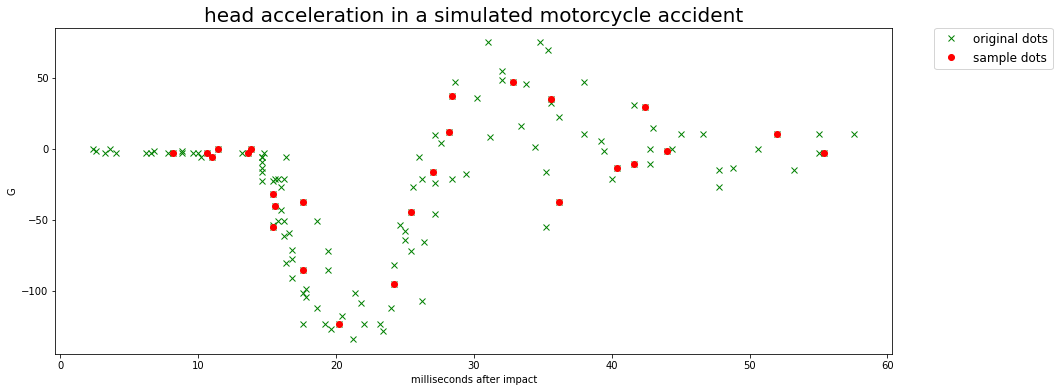

In [8]:
plt.figure(figsize=(15, 6))

plt.title('head acceleration in a simulated motorcycle accident', fontsize=20)
plt.plot(df['times'],df['accel'] ,'x', color='green',label='original dots')

# 部分的なサンプル点
plt.plot(df.times[df.index[sample_index]],df.accel[df.index[sample_index]], 'o', color='red', label='sample dots')

plt.xlabel('milliseconds after impact')
plt.ylabel('G')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()

### 以下のページを参考にコーディング。
### 「pythonでガウス過程を実装する。パラメータの調整はマルコフ連鎖モンテカルロ法（MCMC）を使う」

https://qiita.com/phyblas/items/d756803ec932ab621c56

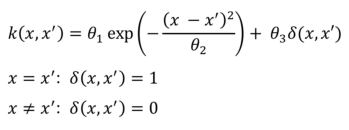

In [217]:
import matplotlib.image as mpimg

img = mpimg.imread('/Users/ShuntaroMiwa/00 python/matsui/gausskernel.png')
plt.axis("off")
imgplot = plt.imshow(img)

In [13]:
class RBFkernel:
    def __init__(self,*param):
        self.param = list(param)

    #a,s,wはパラメータ
    def __call__(self,x1,x2):
        a,s,w = self.param
#         if x1 == x2:
#             delta = 1
#         else:
#             delta = 0 ##←デルタ関数を表現したかったが、行列にうまく対応できなかったため放置。以下のx1==x2でデルタ関数になっているか自信なし。
        return a*np.exp(-1*(x1-x2)**2/s) + w*(x1==x2)

# データの定義
x0 = np.copy(df.times[df.index[sample_index]])
y0 = np.copy(df.accel[df.index[sample_index]])
x1 = np.copy(df.times)
y1 = np.copy(df.accel)

train_length = len(x0)#26回

kernel = RBFkernel(25,25,25) # 適当なパラメータを使うカーネル関数

k00 = kernel(*np.meshgrid(x0,x0))
k00+= k00 + 0.0001 * np.eye(train_length)# 逆行列にあたり、"singular matrix"と出たので、正則化(？)
k00_1 = np.linalg.inv(k00) # 逆行列

#"indexing"は、行列の順序でグリッドを作成
#https://deepage.net/features/numpy-meshgrid.html
k01 = kernel(*np.meshgrid(x0,x1,indexing='ij'))
k10 = k01.T
k11 = kernel(*np.meshgrid(x1,x1))

# ここでは上述の方程式の通りのμとΣ（ガウス過程が従うガウス分布）
mu = k10.dot(k00_1.dot(y0))
sigma = k11 - k10.dot(k00_1.dot(k01))


### "singular matrix"（非正則行列）との表示が出たため、リッジ正則化項を加えた。
### 以下のページによれば、sklearnのガウス過程モジュールでも対角成分にalphaを加える引数"alpha"があるため、問題ないと考える。
##### https://nykergoto.hatenablog.jp/entry/2017/05/29/python%E3%81%A7%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E5%9B%9E%E5%B8%B0_~_%E3%83%A2%E3%82%B8%E3%83%A5%E3%83%BC%E3%83%AB%E3%81%AE%E6%AF%94%E8%BC%83_~

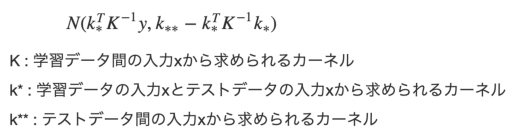

In [228]:
import matplotlib.image as mpimg

plt.figure(figsize=(9, 4))
img = mpimg.imread('/Users/ShuntaroMiwa/00 python/matsui/gauss_dist.png')
plt.axis("off")
imgplot = plt.imshow(img)

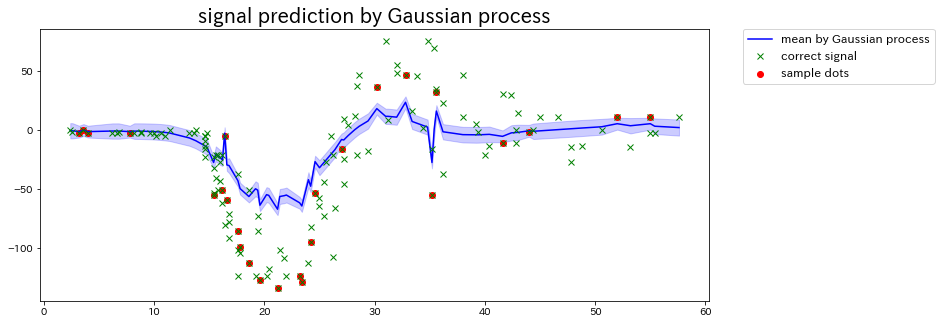

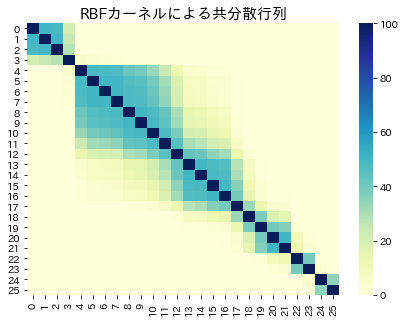

In [229]:
plt.figure(figsize=(12, 5))
plt.title('signal prediction by Gaussian process', fontsize=20)

# 推測された平均μ
plt.plot(x1,mu, color='blue', label='mean by Gaussian process') 

# 各点の標準偏差は共分散行列の対角成分
std = np.sqrt(sigma.diagonal())

# 推測された標準偏差の中の領域
plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='blue') 
# 平均値±(標準偏差×2) … 95.4%の確率で範囲内に指定の数値が現れる

plt.plot(x1,y1, 'x', color='green', label='correct signal')
plt.scatter(x0, y0, color='red', label='sample dots')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('RBFカーネルによる共分散行列', fontsize=15)
sns.heatmap(k00,cmap="YlGnBu")
plt.show()

### x=15〜40くらいまでうまくフィットできていない。信頼区間も多くの箇所でほとんど同じ範囲。「ガウス過程と機械学習」p95-96の記載から、誤差のガウス分布が小さすぎるためではと考えた。

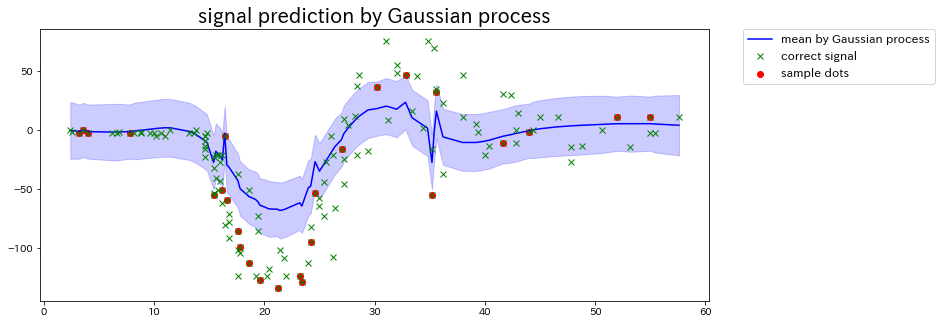

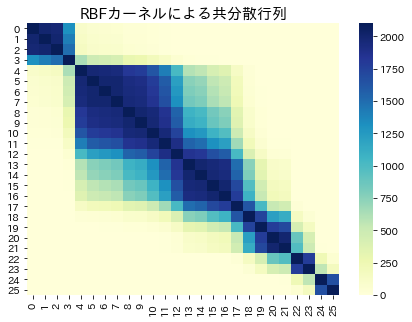

In [230]:
kernel = RBFkernel(1000,50,50) # 適当なパラメータを使うカーネル関数

k00 = kernel(*np.meshgrid(x0,x0))
k00+= k00 + 0.0001 * np.eye(train_length)# 逆行列にあたり、"singular matrix"と出たので、正則化(？)
k00_1 = np.linalg.inv(k00) # 逆行列

#"indexing"は、行列の順序でグリッドを作成
#https://deepage.net/features/numpy-meshgrid.html
k01 = kernel(*np.meshgrid(x0,x1,indexing='ij'))
k10 = k01.T
k11 = kernel(*np.meshgrid(x1,x1))

# ここでは上述の方程式の通りのμとΣ（ガウス過程が従うガウス分布）
mu = k10.dot(k00_1.dot(y0))
sigma = k11 - k10.dot(k00_1.dot(k01))

plt.figure(figsize=(12, 5))
plt.title('signal prediction by Gaussian process', fontsize=20)

# 推測された平均μ
plt.plot(x1,mu, color='blue', label='mean by Gaussian process') 

# 各点の標準偏差は共分散行列の対角成分
std = np.sqrt(sigma.diagonal())

# 推測された標準偏差の中の領域
plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='blue') 
# 平均値±(標準偏差×2) … 95.4%の確率で範囲内に指定の数値が現れる

plt.plot(x1,y1, 'x', color='green', label='correct signal')
plt.scatter(x0, y0, color='red', label='sample dots')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.figure(figsize=(7, 5))
plt.title('RBFカーネルによる共分散行列', fontsize=15)
sns.heatmap(k00,cmap="YlGnBu")
plt.show()

### 手打ちでパラメータを変え何回か出力してみたが、平均値や信頼区間のスムージング（凸凹にしない）ができなかった。

### 以下、MCMC（メトロポリス法）によるパラメータチューニング。

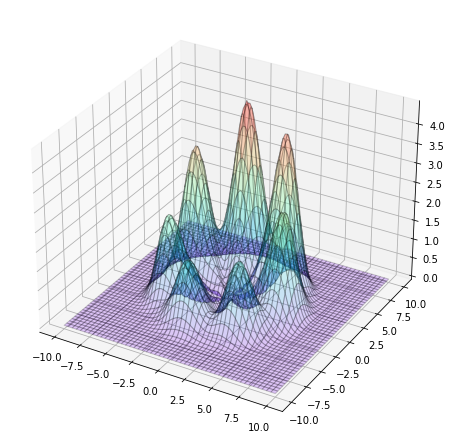

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def fn(xy):
    x,y = xy
    return np.exp(-(5**2-(x**2+y**2))**2/250 + xy[1]/10) * (7./4-np.sin(7*np.arctan2(x,y)))

plt.figure(figsize=[6,6])
mx,my = np.meshgrid(np.linspace(-10,10,101),np.linspace(-10,10,101))
mz = fn([mx,my])
ax = plt.axes([0,0,1,1],projection='3d')
ax.plot_surface(mx,my,mz,rstride=2,cstride=2,alpha=0.2,edgecolor='k',cmap='rainbow')
plt.show()

<ipython-input-10-3d78d29fa548>:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  plt.gca(aspect=1)


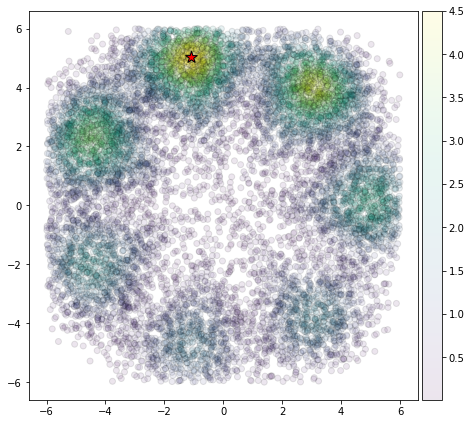

In [10]:
xy0 = np.array([3,-3]) # 開始の位置
bound = np.array([[-6,6],[-6,6]]) # 下限上限
s = (bound[:,1]-bound[:,0])/10. # 毎回どれくらい遠く移動するか
n = 16000 # 何度繰り返すか
xy = [] # 毎回の位置を格納するリスト
p = [] # 毎回の確率を格納するリスト
p0 = fn(xy0) # 開始の位置の確率
for i in range(n):
    idou = np.random.normal(0,s,2) # 移動する距離
    hazure = (xy0+idou<bound[:,0])|(xy0+idou>bound[:,1]) # 下限上限から外れたか
    while(np.any(hazure)):
        idou[hazure] = np.random.normal(0,s,2)[hazure] # 外れたものだけもう一度ランダムする
        hazure = (xy0+idou<bound[:,0])|(xy0+idou>bound[:,1])
    xy1 = xy0 + idou # 新しい位置の候補
    p1 = fn(xy1) # 新しい位置の確率
    r = p1/p0 # 新しい位置と現在の位置の確率の比率
    # 比率は1より高い場合は常に移動するが、低い場合は確率で移動する
    if(r>1 or r>np.random.random()):
        xy0 = xy1 # 現在の位置を新しい位置に移動する
        p0 = p1
        xy.append(xy0) # 新しい位置を格納
        p.append(p0) # 新しい確率を格納

xy = np.stack(xy)
x,y = xy[:,0],xy[:,1]
plt.figure(figsize=[7,6])
plt.gca(aspect=1)
plt.scatter(x,y,c=p,alpha=0.1,edgecolor='k')
plt.colorbar(pad=0.01)
plt.scatter(*xy[np.argmax(p)],s=150,c='r',marker='*',edgecolor='k') # 最大値を星で示す
plt.tight_layout()
plt.show()

In [11]:
class Kernel:
    def __init__(self,param,bound=None):
        self.param = np.array(param)
        if(bound==None):
            bound = np.zeros([len(param),2])
            bound[:,1] = np.inf
        self.bound = np.array(bound)

    def __call__(self,x1,x2):
        a,s,w = self.param
        return a*np.exp(-1*(x1-x2)**2/s) + w*(x1==x2)#a**2*np.exp(-0.5*((x1-x2)/s)**2) + w**2*(x1==x2)    
    
class Gausskatei:
    def __init__(self,kernel):
        self.kernel = kernel

    def gakushuu(self,x0,y0): # パラメータを調整せず学習
        self.x0 = x0
        self.y0 = y0
        self.k00 = self.kernel(*np.meshgrid(x0,x0))
        self.k00+= k00 + 0.0001 * np.eye(train_length) #逆行列がない場合
        self.k00_1 = np.linalg.inv(self.k00)

    def yosoku(self,x): # xからyを予測
        k00_1 = self.k00_1
        k01 = self.kernel(*np.meshgrid(self.x0,x,indexing='ij'))
        k10 = k01.T
        k11 = self.kernel(*np.meshgrid(x,x))

        mu = k10.dot(k00_1.dot(self.y0))
        sigma = k11 - k10.dot(k00_1.dot(k01))
        std = np.sqrt(sigma.diagonal())
        return mu,std

    def logyuudo(self,param=None): # 対数尤度
        if(param is None):
            k00 = self.k00
            k00_1 = self.k00_1
        else:
            self.kernel.param = param
            k00 = self.kernel(*np.meshgrid(self.x0,self.x0))
            k00+= k00 + 0.0001 * np.eye(train_length)
            k00_1 = np.linalg.inv(k00)
        return -(np.linalg.slogdet(k00)[1]+self.y0.dot(k00_1.dot(self.y0)))

    def saitekika(self,x0,y0,kurikaeshi=1000): # パラメータを調整して学習
        self.x0 = x0
        self.y0 = y0
        param = self.kernel.param
        logbound = np.log(self.kernel.bound)
        s = (logbound[:,1]-logbound[:,0])/10.
        n_param = len(param)
        theta0 = np.log(param)
        p0 = self.logyuudo(param)
        lis_theta = []
        lis_p = []
        for i in range(kurikaeshi):
            idou = np.random.normal(0,s,n_param)
            hazure = (theta0+idou<logbound[:,0])|(theta0+idou>logbound[:,1])
            while(np.any(hazure)):
                idou[hazure] = np.random.normal(0,s,n_param)[hazure]
                hazure = (theta0+idou<logbound[:,0])|(theta0+idou>logbound[:,1])
            theta1 = theta0 + idou
            param = np.exp(theta1)
            p1 = self.logyuudo(param)
            r = np.exp(p1-p0)
            if(r>=1 or r>np.random.random()):
                theta0 = theta1
                p0 = p1
                lis_theta.append(theta0)
                lis_p.append(p0)
        self.ar_theta = np.array(lis_theta)
        self.ar_p = np.array(lis_p)
        self.kernel.param = np.exp(lis_theta[np.argmax(lis_p)])
        self.k00 = self.kernel(*np.meshgrid(x0,x0))
        self.k00+= k00 + 0.0001 * np.eye(train_length) #逆行列がない場合
        self.k00_1 = np.linalg.inv(self.k00)

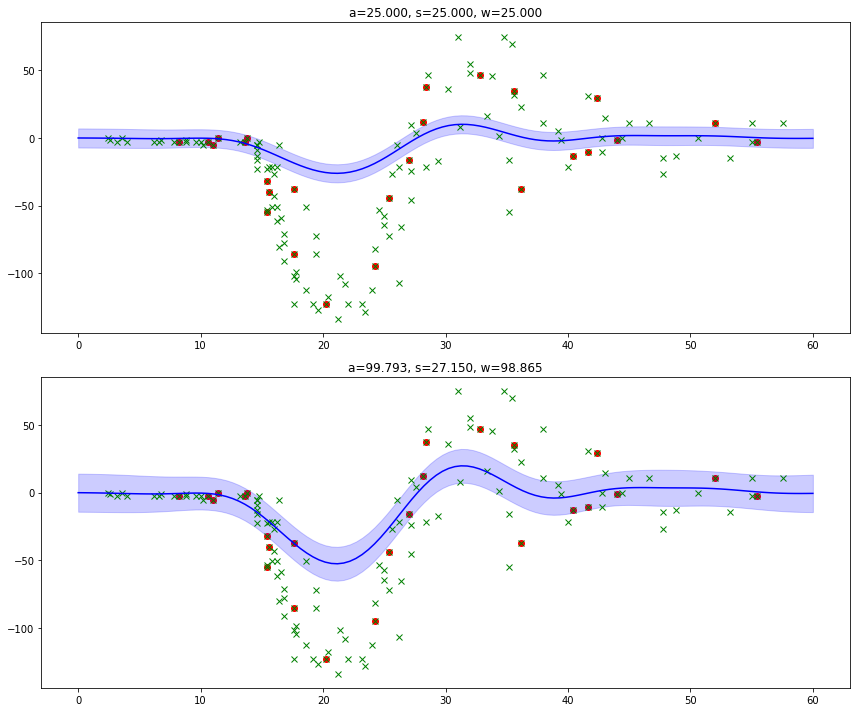

In [14]:
n = 60 # 既知の点の数
# x0 = np.random.uniform(0,100,n) # 既知の点
# y0 = y(x0) + np.random.normal(0,1,n)
param0 = [25,25,25] # パラメータの初期値
bound = [[1e-2,1e2],[1e-2,1e2],[1e-2,1e2]] # 下限上限
kernel = Kernel(param0,bound)
x2 = np.linspace(0,60,120)
gp = Gausskatei(kernel)
gp.gakushuu(x0,y0) # パラメータを調整せずに学習
plt.figure(figsize=[12,10])
for i in [0,1]:
    if(i):
        gp.saitekika(x0,y0,10000) # パラメータを調整する
    plt.subplot(211+i)
    plt.scatter(x0,y0,color='r')
    mu,std = gp.yosoku(x2)
    plt.plot(x1,y1,'x', color='g')
    plt.plot(x2,mu,'b')
    plt.fill_between(x2,mu-std,mu+std,alpha=0.2,color='b')
    plt.title('a=%.3f, s=%.3f, w=%.3f'%tuple(gp.kernel.param))
plt.tight_layout()
plt.show()

### パラメータの上限下限を２桁から４桁に変更する。

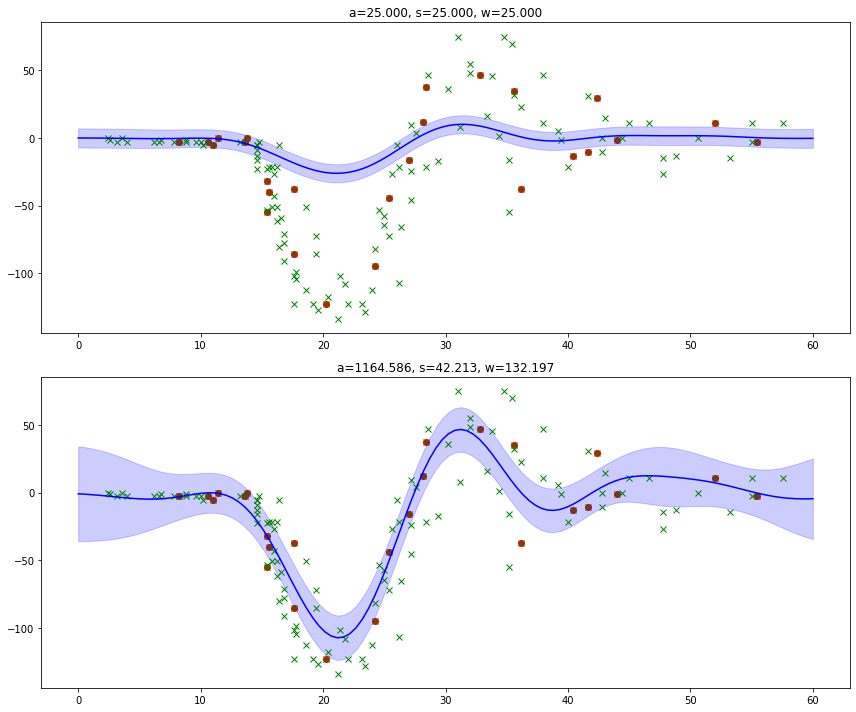

In [15]:
n = 60 # 既知の点の数
# x0 = np.random.uniform(0,100,n) # 既知の点
# y0 = y(x0) + np.random.normal(0,1,n)
param0 = [25,25,25] # パラメータの初期値
bound = [[1e-4,1e4],[1e-4,1e4],[1e-4,1e4]] # 下限上限
kernel = Kernel(param0,bound)
x2 = np.linspace(0,60,120)
gp = Gausskatei(kernel)
gp.gakushuu(x0,y0) # パラメータを調整せずに学習
plt.figure(figsize=[12,10])
for i in [0,1]:
    if(i):
        gp.saitekika(x0,y0,10000) # パラメータを調整する
    plt.subplot(211+i)
    plt.scatter(x0,y0,color='r')
    mu,std = gp.yosoku(x2)
    plt.plot(x1,y1,'x', color='g')# x and y must have same first dimension, but have shapes (200,) and (133, 1)
    plt.plot(x2,mu,'b')
    plt.fill_between(x2,mu-std,mu+std,alpha=0.2,color='b')
    plt.title('a=%.3f, s=%.3f, w=%.3f'%tuple(gp.kernel.param))
plt.tight_layout()
plt.show()

### パラメータaとw（RBFカーネルのθ_1とθ_3）が大きく変わり、うまくフィットした。 
### 以下、GPyパッケージでもやってみた。

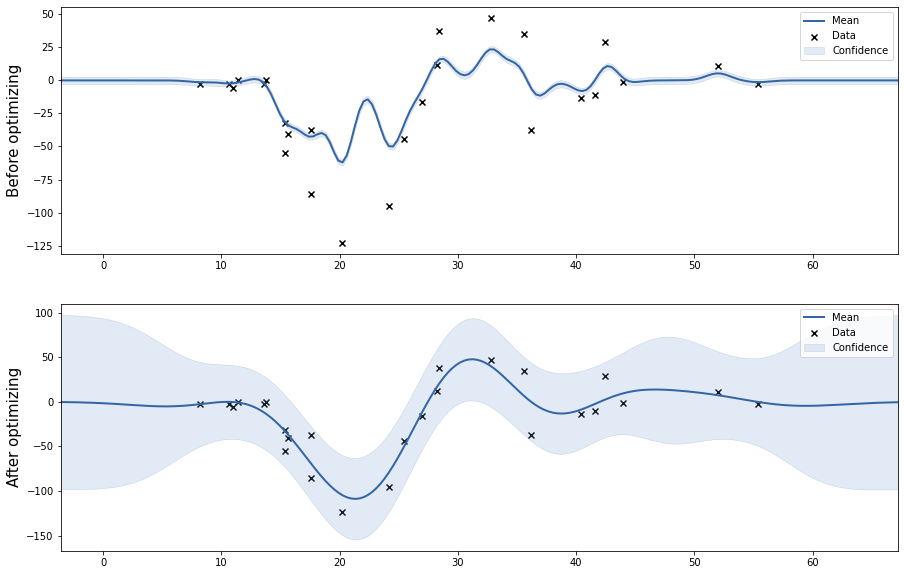

In [19]:
import GPy

kernel = GPy.kern.RBF(1)
# kernel = GPy.kern.RBF(1) + GPy.kern.Bias(1) + GPy.kern.Linear(1)

model = GPy.models.GPRegression(x0[:, None], y0[:, None], kernel=kernel)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
model.plot(ax=ax1)
ax1.set_ylabel("Before optimizing",fontsize=15)

model.optimize()
ax2 = fig.add_subplot(212, sharex=ax1)
model.plot(ax=ax2)
ax2.set_ylabel("After optimizing",fontsize=15)

plt.savefig('fig2.png')



In [151]:
print(model)


Name : GP regression
Objective : 124.59847653781608
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   2633.403596477556  |      +ve      |        
  rbf.lengthscale          |    4.67919761350176  |      +ve      |        
  Gaussian_noise.variance  |  395.84498068553415  |      +ve      |        


### 最適化の手法が異なるためか、パラメータはかなり異なる。MCMCの方が良さげなモデルとなっていた。（情報量基準がないため、比較はできないのか？と疑問を持った）
### 以下、maternカーネルでもやってみた（違いは分からなかった）。

Text(0, 0.5, 'After optimizing')

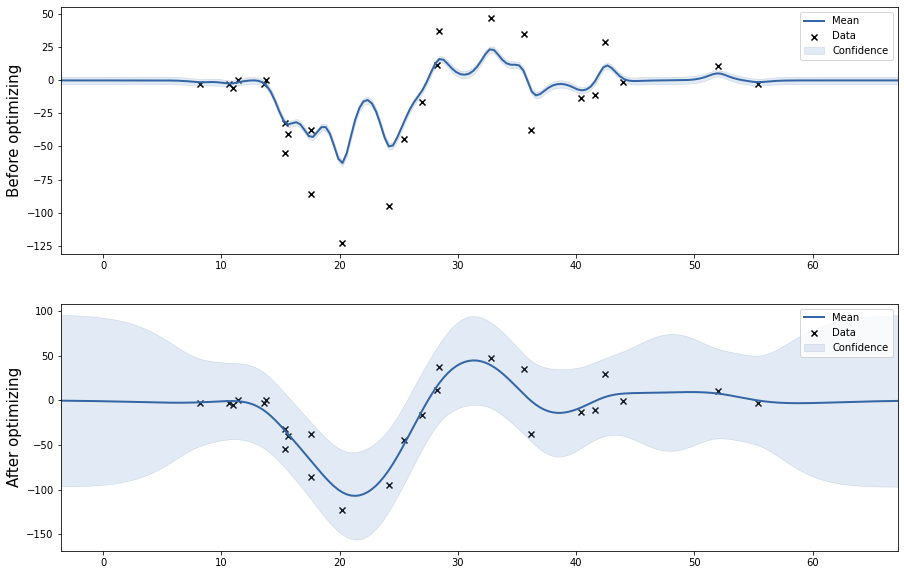

In [32]:
kernel = GPy.kern.Matern52(1)
#kernel = GPy.kern.RBF(1) + GPy.kern.Bias(1) + GPy.kern.Linear(1)

model = GPy.models.GPRegression(x0[:, None], y0[:, None], kernel=kernel)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
model.plot(ax=ax1)
ax1.set_ylabel("Before optimizing",fontsize=15)

model.optimize()
ax2 = fig.add_subplot(212, sharex=ax1)
model.plot(ax=ax2)
ax2.set_ylabel("After optimizing",fontsize=15)
